# Este notebook realiza la comparación para resolver el issue #20:
# Mini EDA de respuestas con URL inválido en columna ARCHIVO

Cada registro en la solicitud tiene una columna ARCHIVO donde hay un URL de donde se puede descargar un adjunto que enriquece (o no) la respuesta.

Algunos de estos URLs son inválidos, inexistentes, retornan adjuntos vacíos, ZIP vacíos, o solo regresan una página en blanco.

Se pide realizar mini EDA de estos casos en particular para responder lo siguiente:

Hay un patrón claro de adjuntos que van desapareciendo en el tiempo, o la cantidad de adjuntos invalidos es aproximadamente la misma en todos los años?
Existe alguna concentración de adjuntos erróneos en alguna dependencia?

**A DISCUSIÓN:** finalizar con la adición del feature calidad_adjunto, donde se le asigna un 1 si tiene un adjunto descargable o accesible, y -1 si es un URL inválido.

In [1]:
import boto3
import pyarrow
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
f = f's3://inai-summerofdata/parquet/inai.parquet'
df = pd.read_parquet(f, engine='pyarrow')
df.head()

,FOLIO,FECHASOLICITUD,DEPENDENCIA,ESTATUS,MEDIOENTRADA,TIPOSOLICITUD,DESCRIPCIONSOLICITUD,OTROSDATOS,ARCHIVOADJUNTOSOLICITUD,MEDIOENTREGA,...,ARCHIVORESPUESTA,FECHARESPUESTA,PAIS,ESTADO,MUNICIPIO,CODIGOPOSTAL,SECTOR,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto
0,1857500001912,2012/01/01 05:04:07,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Copia de los documentos y los datos con que cu...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...
1,1857500002012,2012/01/01 05:13:16,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Del ATG para precisar información y datos usa...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...
2,0001800000712,2012/01/01 09:46:39,SECRETARÍA DE ENERGÍA,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Energía,zip,2.0,None
3,0000600003712,2012/01/01 10:11:41,SECRETARÍA DE HACIENDA Y CRÉDITO PÚBLICO,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Hacienda y Crédito Público,pdf,1.0,INIDOS SECRETARIA DE HACIENDA Y CREDITO PUBLI...
4,0001500002812,2012/01/01 10:32:15,SECRETARÍA DE DESARROLLO AGRARIO TERRITORIAL ...,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/01,México,Distrito Federal,MIGUEL HIDALGO,11230,Reforma Agraria,zip,4.0,None


Hacemos las categorías de `ARCHIVORESPUESTA`

In [101]:
my_df = df[~df['ARCHIVORESPUESTA'].isnull()]
#my_df.head()
my_df['category_url'] = my_df['ARCHIVORESPUESTA']
#my_df.head()
my_df.loc[my_df["category_url"].str.contains('https', case=False, na=None), "category_url"] = 'url'
#my_df.head()
#my_df['category_url'].unique()
data = [my_df["FOLIO"], my_df["category_url"]]

headers = ["FOLIO", "category_url"]

df3 = pd.concat(data, axis=1, keys=headers)
#df3.head()

df_nuevo = pd.merge(df, df3, how='left', on=['FOLIO', 'FOLIO'])
df_nuevo.head()

<ipython-input-101-4ee7c38f1f3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df['category_url'] = my_df['ARCHIVORESPUESTA']
/home/rafaelortega/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,FOLIO,FECHASOLICITUD,DEPENDENCIA,ESTATUS,MEDIOENTRADA,TIPOSOLICITUD,DESCRIPCIONSOLICITUD,OTROSDATOS,ARCHIVOADJUNTOSOLICITUD,MEDIOENTREGA,...,FECHARESPUESTA,PAIS,ESTADO,MUNICIPIO,CODIGOPOSTAL,SECTOR,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,category_url
0,1857500001912,2012/01/01 05:04:07,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Copia de los documentos y los datos con que cu...,None,None,Entrega por Internet en el INFOMEX,...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...,url
1,1857500002012,2012/01/01 05:13:16,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Del ATG para precisar información y datos usa...,None,None,Entrega por Internet en el INFOMEX,...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...,url
2,0001800000712,2012/01/01 09:46:39,SECRETARÍA DE ENERGÍA,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Energía,zip,2.0,None,url
3,0000600003712,2012/01/01 10:11:41,SECRETARÍA DE HACIENDA Y CRÉDITO PÚBLICO,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Hacienda y Crédito Público,pdf,1.0,INIDOS SECRETARIA DE HACIENDA Y CREDITO PUBLI...,url
4,0001500002812,2012/01/01 10:32:15,SECRETARÍA DE DESARROLLO AGRARIO TERRITORIAL ...,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/01,México,Distrito Federal,MIGUEL HIDALGO,11230,Reforma Agraria,zip,4.0,None,url


En primer lugar, extraemos los valores que nos interesan:

In [102]:
df_filtrado1 = df_nuevo[df_nuevo['tipo_archivo_respuesta'].isna()]
df_filtrado2 = df_nuevo[df_nuevo['tipo_archivo_respuesta']=='zip']
df_filtrado3 = df_nuevo[df_nuevo['tipo_archivo_respuesta']=='ZIP']
df_filtrado4 = df_filtrado2.append(df_filtrado3)
df_filtrado5 = df_nuevo[df_nuevo['cantidad_archivos_respuesta']==0]
df_filtrado = df_filtrado1.append(df_filtrado5)
len(df_filtrado)

576237

En total, tenemos esta cantidad de renglones que no tienen un pdf o archivo utilizable:

In [103]:
len(df_filtrado)

576237

De los registros que tienen url, ¿cuantos tienen un archivo no utilizable?

In [104]:
df_url = df_nuevo[df_nuevo['category_url']=='url']
df_url.head()

,FOLIO,FECHASOLICITUD,DEPENDENCIA,ESTATUS,MEDIOENTRADA,TIPOSOLICITUD,DESCRIPCIONSOLICITUD,OTROSDATOS,ARCHIVOADJUNTOSOLICITUD,MEDIOENTREGA,...,FECHARESPUESTA,PAIS,ESTADO,MUNICIPIO,CODIGOPOSTAL,SECTOR,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,category_url
0,1857500001912,2012/01/01 05:04:07,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Copia de los documentos y los datos con que cu...,None,None,Entrega por Internet en el INFOMEX,...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...,url
1,1857500002012,2012/01/01 05:13:16,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Del ATG para precisar información y datos usa...,None,None,Entrega por Internet en el INFOMEX,...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...,url
2,0001800000712,2012/01/01 09:46:39,SECRETARÍA DE ENERGÍA,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Energía,zip,2.0,None,url
3,0000600003712,2012/01/01 10:11:41,SECRETARÍA DE HACIENDA Y CRÉDITO PÚBLICO,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Hacienda y Crédito Público,pdf,1.0,INIDOS SECRETARIA DE HACIENDA Y CREDITO PUBLI...,url
4,0001500002812,2012/01/01 10:32:15,SECRETARÍA DE DESARROLLO AGRARIO TERRITORIAL ...,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/01,México,Distrito Federal,MIGUEL HIDALGO,11230,Reforma Agraria,zip,4.0,None,url


In [105]:
len(df_url)

1049169

In [106]:
num_por_tipos = df_url['tipo_archivo_respuesta'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['tipo_archivo_respuesta'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

,tipo_archivo_respuesta,porcentaje
pdf,550781,52.5%
zip,334303,31.86%
doc,87832,8.37%
NaN,66375,6.33%
PDF,7531,0.72%
xls,2152,0.21%
DOC,79,0.01%
ZIP,67,0.01%
docx,37,0.0%
xlsx,4,0.0%


De los registros que tienen un url, en el 6.33% de los casos no se pudo obtener un archivo de respuesta

In [107]:
df_archivoresp_na_con_url = df_url[df_url['tipo_archivo_respuesta'].isnull()]
df_archivoresp_na_con_url.head()

,FOLIO,FECHASOLICITUD,DEPENDENCIA,ESTATUS,MEDIOENTRADA,TIPOSOLICITUD,DESCRIPCIONSOLICITUD,OTROSDATOS,ARCHIVOADJUNTOSOLICITUD,MEDIOENTREGA,...,FECHARESPUESTA,PAIS,ESTADO,MUNICIPIO,CODIGOPOSTAL,SECTOR,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,category_url
8,0000400002412,2012/01/01 11:33:14,SECRETARÍA DE GOBERNACIÓN (INCLUYE LA ENTONCES...,Terminada,Electrónica,Información Pública,Agradeceré se me proporciones en archivo magné...,None,None,Entrega por Internet en el INFOMEX,...,2012/01/05,México,Distrito Federal,MIGUEL HIDALGO,11230,Gobernación,None,NaN,None,url
35,0715000000712,2012/01/01 14:54:01,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,Terminada,Electrónica,Información Pública,Con fundamento en lo previsto en los Artículos...,Por favor no referenciar a COMPRANET; la prese...,None,Entrega por Internet en el INFOMEX,...,2012/01/23,México,México,NAUCALPAN DE JUAREZ,53840,Aportaciones a Seguridad Social,None,NaN,None,url
71,1111500000512,2012/01/01 19:58:15,COLEGIO DE BACHILLERES,Desechada por falta de respuesta del ciudadano,Electrónica,Información Pública,del año 2005 al año 2011 cuanto dinero se pago...,None,None,Entrega por Internet en el INFOMEX,...,2012/01/05,México,Distrito Federal,XOCHIMILCO,16070,Educación Pública,None,NaN,None,url
90,1857500003512,2012/01/01 21:25:52,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Solicito atentamente me proporcionen la siguie...,None,None,Entrega por Internet en el INFOMEX,...,2012/01/16,México,Tabasco,CENTRO,86035,Energía,None,NaN,None,url
96,1857500004012,2012/01/01 21:32:03,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Solicito atentamente me proporcionen la siguie...,None,None,Entrega por Internet en el INFOMEX,...,2012/01/12,México,Tabasco,CENTRO,86035,Energía,None,NaN,None,url


Viendolo en los años:

In [108]:
for col in ['FECHASOLICITUD', 'FECHARESPUESTA']:#, 'FECHALIMITE']:
    df_archivoresp_na_con_url[col] = pd.to_datetime(df_archivoresp_na_con_url[col],format= "%Y-%m-%d %H:%M:%S")

<ipython-input-108-e34a4ff38269>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_archivoresp_na_con_url[col] = pd.to_datetime(df_archivoresp_na_con_url[col],format= "%Y-%m-%d %H:%M:%S")


In [113]:
df_archivoresp_na_con_url['año_solicitud'] = pd.DatetimeIndex(df_archivoresp_na_con_url['FECHASOLICITUD']).year
#df_archivoresp_na_con_url.head()
df_url['año_solicitud'] = pd.DatetimeIndex(df_url['FECHASOLICITUD']).year
#df_url.head()

<ipython-input-113-64bfc8cbc36c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_archivoresp_na_con_url['año_solicitud'] = pd.DatetimeIndex(df_archivoresp_na_con_url['FECHASOLICITUD']).year
<ipython-input-113-64bfc8cbc36c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_url['año_solicitud'] = pd.DatetimeIndex(df_url['FECHASOLICITUD']).year


#### Hay un patrón claro de adjuntos que van desapareciendo en el tiempo, o la cantidad de adjuntos invalidos es aproximadamente la misma en todos los años?

## Distribución de los archivos no utilizables por año

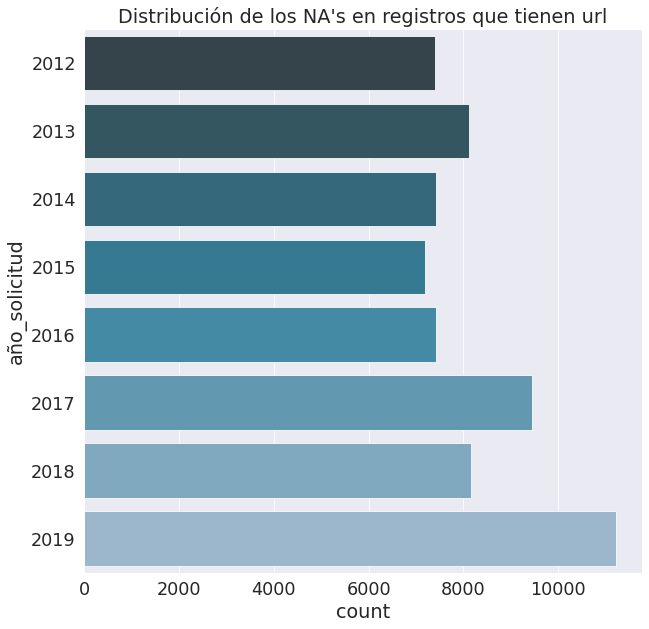

In [111]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los NA's en registros que tienen url")
ax = sns.countplot(y="año_solicitud", data=df_archivoresp_na_con_url, palette="PuBuGn_d")

In [115]:
num_por_tipos = df_archivoresp_na_con_url['año_solicitud'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_archivoresp_na_con_url['año_solicitud'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

,año_solicitud,porcentaje
2019,11210,16.89%
2017,9447,14.23%
2018,8163,12.3%
2013,8114,12.22%
2016,7431,11.2%
2014,7430,11.19%
2012,7392,11.14%
2015,7188,10.83%


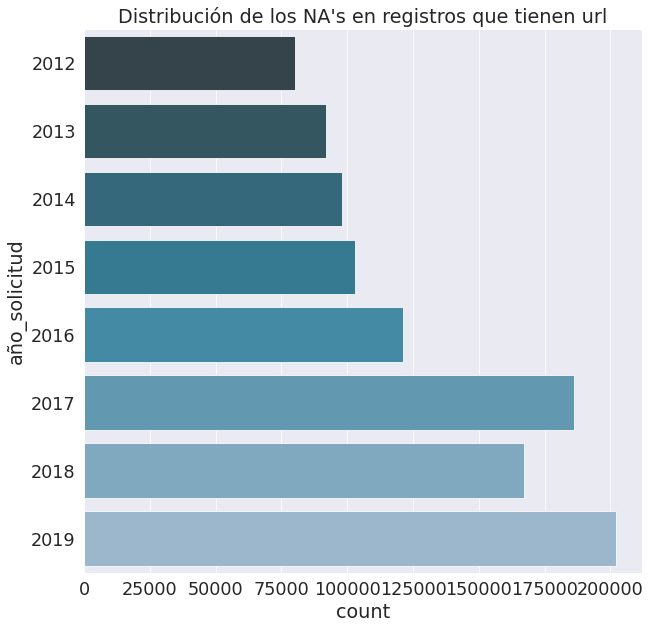

In [114]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los NA's en registros que tienen url")
ax = sns.countplot(y="año_solicitud", data=df_url, palette="PuBuGn_d")

In [116]:
num_por_tipos = df_url['año_solicitud'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['año_solicitud'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df

,año_solicitud,porcentaje
2019,201949,19.25%
2017,186125,17.74%
2018,167061,15.92%
2016,121044,11.54%
2015,102972,9.81%
2014,97864,9.33%
2013,91934,8.76%
2012,80220,7.65%


## Distribución de los archivos no utilizables por `DEPENDENCIA`

#### Existe alguna concentración de adjuntos erróneos en alguna dependencia?

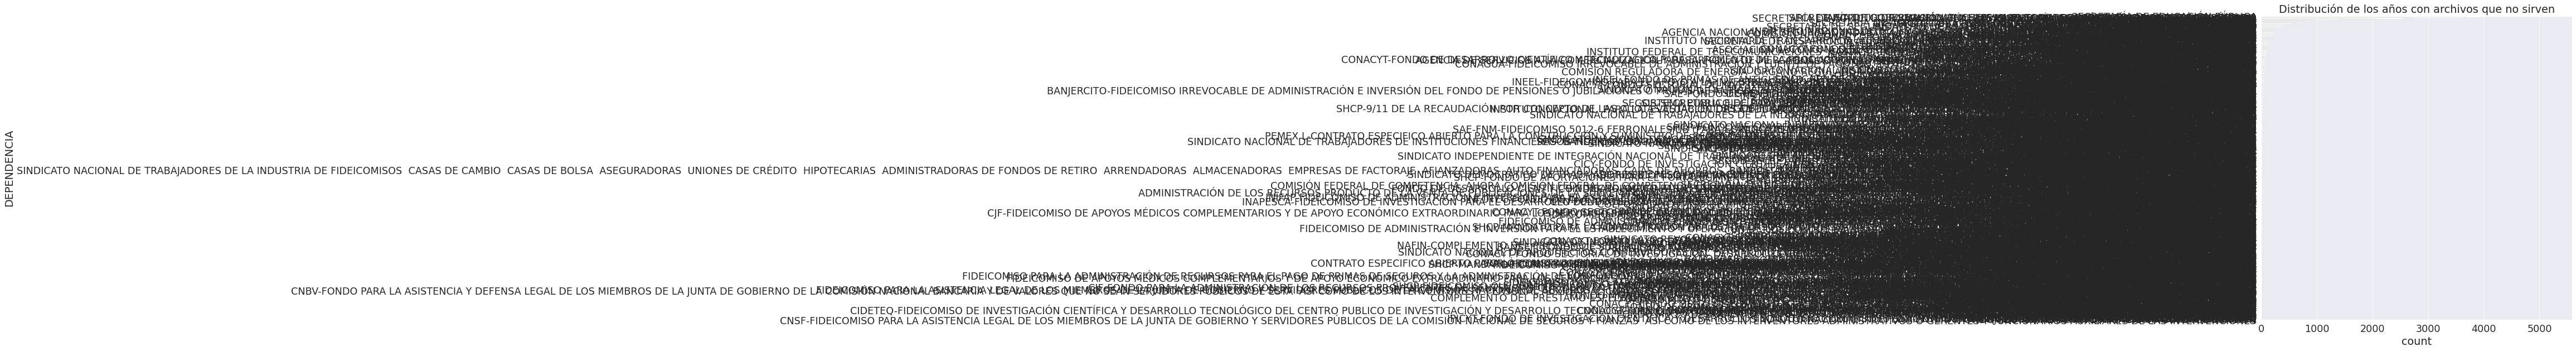

In [117]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años con archivos que no sirven")
ax = sns.countplot(y="DEPENDENCIA", data=df_archivoresp_na_con_url,order = df_archivoresp_na_con_url['DEPENDENCIA'].value_counts().index, palette="PuBuGn_d")

In [118]:
pd.set_option('display.max_rows', None)
num_por_tipos = df_archivoresp_na_con_url['DEPENDENCIA'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_archivoresp_na_con_url['DEPENDENCIA'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df.head()

,DEPENDENCIA,porcentaje
SECRETARÍA DE EDUCACIÓN PÚBLICA,5321,8.02%
SECRETARÍA DE GOBERNACIÓN (INCLUYE LA ENTONCES SECRETARÍA DE SEGURIDAD PÚBLICA),3922,5.91%
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO,3675,5.54%
SECRETARÍA DE AGRICULTURA GANADERÍA DESARROLLO RURAL PESCA Y ALIMENTACIÓN (SAGARPA),3610,5.44%
COMISIÓN FEDERAL PARA LA PROTECCIÓN CONTRA RIESGOS SANITARIOS,2737,4.12%


Pero ¿en realidad está aumentando el número de solicitudes al año?

## Distribución de número de solicitudes por año

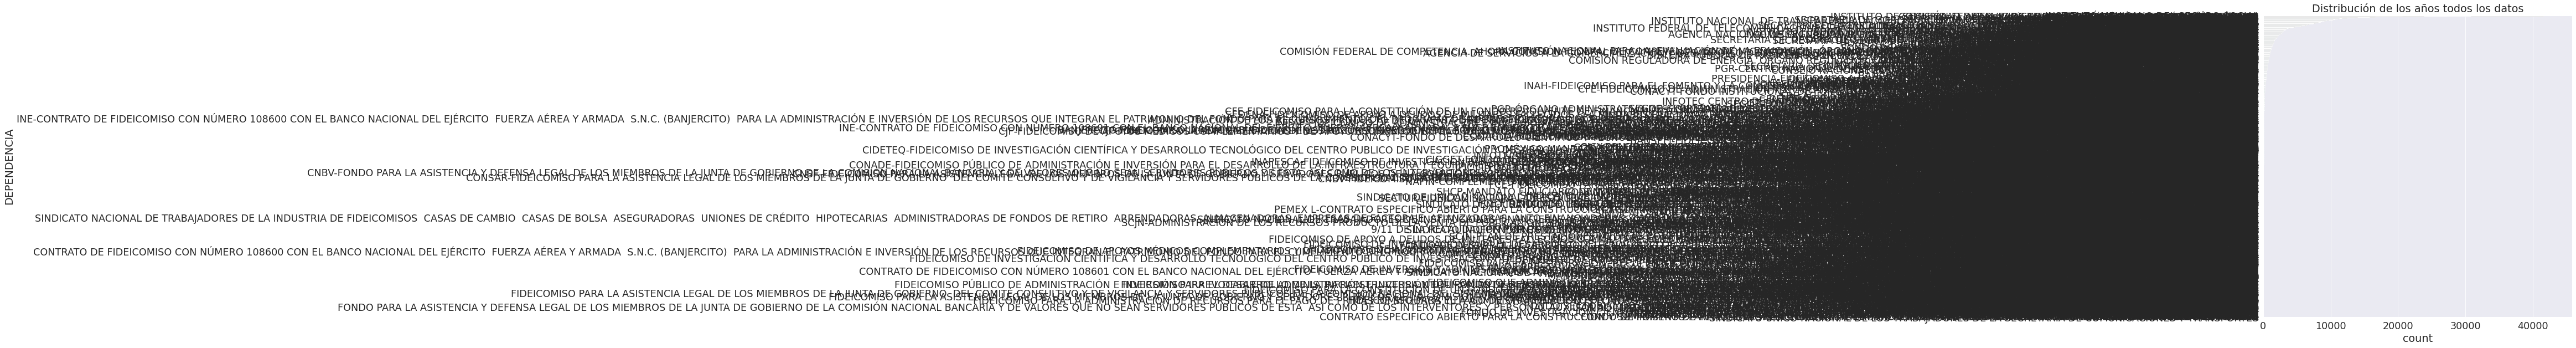

In [119]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="DEPENDENCIA", data=df_url,order = df_url['DEPENDENCIA'].value_counts().index, palette="PuBuGn_d")

In [120]:
pd.set_option('display.max_rows', None)
num_por_tipos = df_url['DEPENDENCIA'].value_counts(dropna=False)
#num_por_tipos
num_por_tipos_df = pd.DataFrame(data=num_por_tipos)
num_por_tipos_df['porcentaje'] = df_url['DEPENDENCIA'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str)+'%'
num_por_tipos_df.head()

,DEPENDENCIA,porcentaje
INSTITUTO MEXICANO DEL SEGURO SOCIAL,43647,4.16%
COMISIÓN FEDERAL PARA LA PROTECCIÓN CONTRA RIESGOS SANITARIOS,41553,3.96%
INSTITUTO MEXICANO DEL SEGURO SOCIAL (IMSS),30801,2.94%
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO,27292,2.6%
SECRETARÍA DE EDUCACIÓN PÚBLICA,23867,2.27%
